In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
from tqdm import tqdm
from collections import Counter
from novelty.metrics import softmax
from novelty.afa import adaptive_filter
import networkx as nx
import math 
from itertools import combinations
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams['font.family'] = 'Aptos'

In [2]:
# Import Metadata
metadata = pd.read_csv('/home/rb/Documents/Data/metadata/metadata-full.tsv',sep='\t',parse_dates=['date'])
metadata = metadata[metadata.session_type == 'plenary']
metadata['py'] = metadata.speech_id.str.split('.').str[4].str[:8]
metadata['sess'] = metadata.speech_id.str.split('.').str[4:6].agg('.'.join)

names = dict(zip(metadata['member-ref'],metadata.speaker))
parties = dict(zip(metadata['member-ref'],metadata['party-ref']))

# Date Dictionaries
dates_topic = dict(zip(metadata.speech_id.str.split('.').str[4:6].str.join('.'), metadata.date))
dates_speech = dict(zip(metadata.speech_id, metadata.date))

In [3]:
# Change dates to 6-month bins, select only MPs, Plenaries, and remove joint House meetings

metadata['date'] = metadata.date.apply(lambda d: pd.Timestamp(year = d.year, month=1 if d.month < 7 else 6, day=1))
subset = metadata[(metadata.role == 'mp') & (metadata.session_type == 'plenary') & ~(metadata.py.str.endswith('0000')) & (metadata.date.dt.year > 1945)]

In [5]:
# Loop over periods and members. Calculate PMI between member-member pairs based on co-occurrence in session

r = []

for py, t in tqdm(subset.groupby(['date'])):
    
    t = t[t['member-ref'].map(t['member-ref'].value_counts()) > 10]
    total_sessions = t.sess.nunique()

    for member1, session_dat1 in t.groupby('member-ref'):
        for member2, session_dat2 in t.groupby('member-ref'):
            if member1 != member2:
                f1 = session_dat1.sess.nunique()
                f2 = session_dat2.sess.nunique()
                f12 = len(set(session_dat1.sess.unique()).intersection(set(session_dat2.sess.unique())))
                if f12 > 5:
                    pmi = np.log2((f12 / total_sessions) / ((f1 / total_sessions) * (f2 / total_sessions)))
                    r.append({'member1':member1, 'member2':member2,'pmi': pmi,'py':py, 'totsess':total_sessions,'f12':f12, 'f1':f1, 'f2':f2})
                else:
                    r.append({'member1':member1, 'member2':member2,'pmi': -100,'py':py, 'totsess':total_sessions,'f12':f12, 'f1':f1, 'f2':f2})

  0%|          | 0/98 [00:00<?, ?it/s]

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/std.py:1195: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for obj in iterable:
100%|██████████| 98/98 [02:15<00:00,  1.38s/it]


In [6]:
rd = pd.DataFrame(r)

In [7]:
rdn = rd[rd.pmi > 0]

In [6]:
# Based on the PMI-values, aggregate different signals

signals = pd.DataFrame({"py":sorted(rdn.py.unique())})

## Mean
signals = pd.merge(signals,rdn.groupby('py').pmi.mean().reset_index(name='mean_'), on='py')


## Variation
signals = pd.merge(signals,rdn.groupby('py').pmi.var().reset_index(name='variation'), on='py')

## Concentration
signals = pd.merge(signals,rdn.groupby('py').apply(lambda t:entropy(softmax(t.pmi))).reset_index(name='entropy'), on='py')

## Modularity
def get_mod(df):
    # df = df.groupby('member1').apply(lambda g: g.nlargest(10,'pmi'))
    G = nx.from_pandas_edgelist(df = df, source = 'member1', target = 'member2', edge_attr='pmi')
    comms = nx.community.louvain_communities(G,weight='pmi')
    return nx.community.quality.modularity(G,communities=comms)

# Smooth Signals, Remove Prewar debates
signals = pd.merge(signals,rdn[rdn.pmi > 0].groupby('py').apply(get_mod).reset_index(name='modularity'), on='py')
signals = signals[signals.py.dt.year > 1945].set_index('py').apply(zscore)
for c in signals.columns:
    signals[c] = adaptive_filter(signals[c],span=10)

In [7]:
def plot_kde(rdn,year,ax):
    sns.kdeplot(rdn[rdn.py.dt.year // 10 * 10 == year],x='pmi',fill=True,color='black',ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(year)
    ax.set_xlim(-1,5)
    ax.set_ylim(0,0.6)
    ax.axvline(x=2.5,ymin=0,ymax=1,linestyle='--',color='gold',lw=1)
    ax.axhline(y=.25,xmin=-1,xmax=5,linestyle='--',color='gold',lw=1)

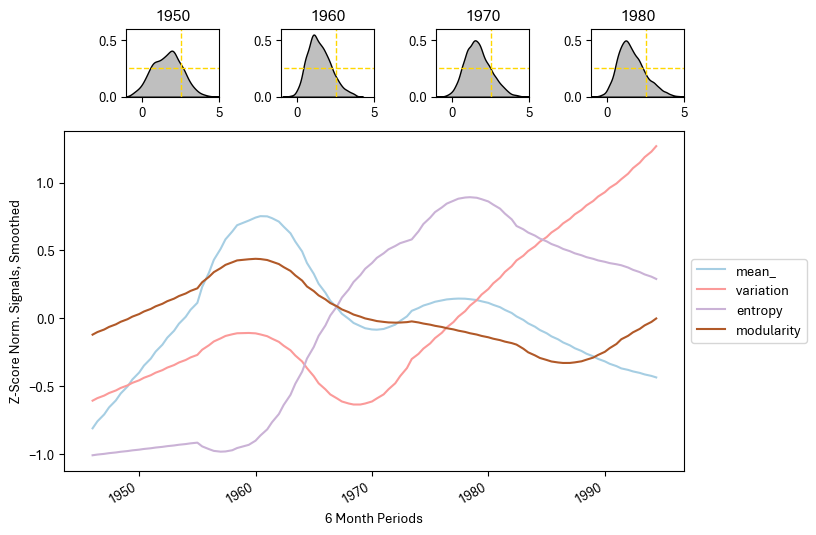

In [9]:
# Plot

f,a = plt.subplots(figsize=(8,5))

signals.plot(cmap='Paired',ylabel='Z-Score Norm. Signals, Smoothed',xlabel='6 Month Periods',ax=a)

a.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ins1 = a.inset_axes([0.1,1.1,0.15,0.2])
plot_kde(rdn,1950,ins1)

ins1 = a.inset_axes([0.35,1.1,0.15,0.2])
plot_kde(rdn,1960,ins1)

ins1 = a.inset_axes([0.6,1.1,0.15,0.2])
plot_kde(rdn,1970,ins1)

ins1 = a.inset_axes([0.85,1.1,0.15,0.2])
plot_kde(rdn,1980,ins1)
plt.show()

In [11]:
G = nx.from_pandas_edgelist(df = rdn[rdn.py.dt.year == 1970], source = 'member1', target = 'member2', edge_attr='pmi')
comms = nx.community.louvain_communities(G,weight='pmi',resolution=3)